# Create our environment (connect-4 game)

Connect-4 is a game in which if one were to connect 4 of his moves either horizontally, vertically or diagonally, one records a win. In reinforcement learning setting, we grant reward = 1 for a win, -1 for a lose and 0.5 for a draw. The following game engine object provides five methods.
* Render :  
       Showing the board state with X and Os.
* Reset : 
       For playing over and over.
* Get available moves : 
       Scan the board state and give available moves.
* Check game done : 
       Based on which player is making the move, check if one has won the game or a draw has resulted.
* Make move : 
       Record the move by players and return observation and reward.

In [5]:
import numpy as np
import pandas as pd
from IPython.display import display

class connect_x:

    def __init__(self):
        self.board_height = 6
        self.board_width = 7
        self.board_state = np.zeros([self.board_height, self.board_width], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2}
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'lose': -1}
    
    def render(self):
        rendered_board_state = self.board_state.copy().astype(str)
        rendered_board_state[self.board_state == 0] = ' '
        rendered_board_state[self.board_state == 1] = 'O'
        rendered_board_state[self.board_state == 2] = 'X'
        display(pd.DataFrame(rendered_board_state))
    
    def reset(self):
        self.__init__()
        
    def get_available_actions(self):
        available_cols = []
        for j in range(self.board_width):
            if np.sum([self.board_state[:, j] == 0]) != 0:
                available_cols.append(j)
        return available_cols
    
    def check_game_done(self, player):
        if player == 'p1':
            check = '1 1 1 1'
        else:
            check = '2 2 2 2'
        
        # check vertically then horizontally
        for j in range(self.board_width):
            if check in str(self.board_state[:, j]):
                self.isDone = True
        for i in range(self.board_height):
            if check in str(self.board_state[i, :]):
                self.isDone = True
        
        # check left diagonal and right diagonal
        for k in range(0, self.board_height - 4 + 1):
            left_diagonal = np.array([self.board_state[k + d, d] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d + k, self.board_width - d - 1] for d in \
                            range(min(self.board_height - k, min(self.board_height, self.board_width)))])
            if check in str(left_diagonal) or check in str(right_diagonal):
                self.isDone = True
        for k in range(1, self.board_width - 4 + 1):
            left_diagonal = np.array([self.board_state[d, d + k] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            right_diagonal = np.array([self.board_state[d, self.board_width - 1 - k - d] for d in \
                            range(min(self.board_width - k, min(self.board_height, self.board_width)))])
            if check in str(left_diagonal) or check in str(right_diagonal):
                self.isDone = True
        
        if self.isDone:
            return self.reward['win']
        # check for draw
        elif np.sum([self.board_state == 0]) == 0:
            self.isDone = True
            return self.reward['draw']
        else:
            return 0.
        
    def make_move(self, a, player):
        # check if move is valid
        if a in self.get_available_actions():
            i = np.sum([self.board_state[:, a] == 0]) - 1
            self.board_state[i, a] = self.players[player]
        else:
            print('Move is invalid')
            self.render()

        reward = self.check_game_done(player)
        
        # give feedback as new state and reward
        return self.board_state.copy(), reward

env = connect_x()

# Experience replay

We’ll be using experience replay for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.  

For a brief review of more advanced sampling algorithm mentioned in AlphaGo zero, its sampling procedure can be divided into 3 phases.

* Optimization:
      It checkpoints the deep learning agent by recording its weights every 1000 training iterations. 
* Evaluation:
      Evaluate the checkpoints model by letting the two playing against each other for 400 games, the one wins > 55% will become the current best model (with epsilon = 0 = no exploration). 
* Self-play: 
      They will only use the current best model or player to generate training data for the optimization step.  

For a more deep dive of the AlphaGo zero's impressive algorithm, readers can refer to the <a href="https://discovery.ucl.ac.uk/id/eprint/10045895/1/agz_unformatted_nature.pdf">original paper</a> or this post - <a href="https://medium.com/@jonathan_hui/alphago-zero-a-game-changer-14ef6e45eba5">AlphaGo Zero — a game changer</a>, the author did a great job of summarizing the details from MCTS, ResNet to self-playing. 

In [9]:
import random

# memory block for deep q learning
class replayMemory:
    def __init__(self):
        self.memory = []
        
    def dump(self, transition_tuple):
        self.memory.append(transition_tuple)
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
memory = replayMemory()

# Deep Q-network

Our model will be using a convolutional neural network that takes into the state as an image of board_state and output the state action function value for all states. In effect, the network is trying to predict the expected return of taking each action given the current input. But be aware that, the game's action space is changing so agent can only take legal actions.  

More advanced way to deal with training a better function approximator for fully observation games like Go and Connect-4 is to preprocess input images. AlphaGo zero separated the training input image into two binary matrix of 0 and 1s made by white and black stones. Also, to handle strategic moves better, it includes the history (last 8 moves of game) as input, plus 1 extra dimension as 0 or 1 indicating whether it is the players turn to make a move, in their case, the input is therfore 19 \* 19 \* 17 (2 * 8 + 1) image vector. The output is a policy vector of 19 \* 19 (the probabilities of making a moves) and a state value scalar.  

For fast experimentation, our DQN will just use a single image map as 6 \* 7 \* 1 with 1 as the moves made by player 1 and 2 as the moves made by player 2.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    
    def __init__(self, outputs):
        super(DQN, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(linear_input_size, 50)
        self.MLP2 = nn.Linear(50, 50)
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)

# Agent
Below created 2 models of the same DQN object, termed as target_net and policy_net. The creation of 2 nets instead of 1 is to stablilize the training by a lagged goal provided by target_net. The reasonale behind this will be explained more in the "Optimizing policy" section.  

To accelerate training with at least 100x, below uses the free CPU provided by Google Colab. To use GPU in Pytorch, first is setting the CUDA device, then send the model, input and output tensors to GPU memory.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


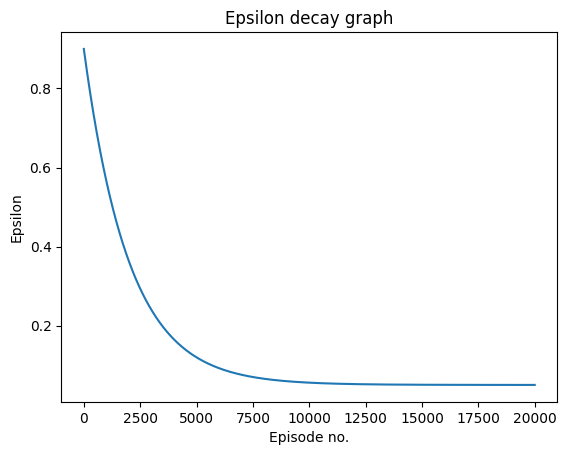

In [19]:
import matplotlib.pyplot as plt
# epilson decay graph
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 2000

steps_done = np.arange(20000)
eps = EPS_END + (EPS_START - EPS_END) * np.exp(-1 * steps_done / EPS_DECAY)
plt.plot(steps_done, eps)
plt.title('Epsilon decay graph')
plt.xlabel('Episode no.')
plt.ylabel('Epsilon')
plt.show()

In [20]:
import torch.optim as optim
import math

BATCH_SIZE = 256
GAMMA = 0.999

# get max no. of actions from action space
n_actions = env.board_width

height = env.board_height
width = env.board_width

policy_net = DQN(n_actions).to(device)
# target_net will be updated every n episodes to tell policy_net a better estimate of how far off from convergence
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# set target_net in testing mode
target_net.eval()

optimizer = optim.Adam(policy_net.parameters())

def select_action(state, available_actions, steps_done=None, training=True):
    # batch and color channel
    state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(dim=0).unsqueeze(dim=0)
    epsilon = random.random()
    if training:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY)
    else:
        eps_threshold = 0
    
    # follow epsilon-greedy policy
    if epsilon > eps_threshold:
        with torch.no_grad():
            # action recommendations from policy net
            r_actions = policy_net(state)[0, :]
            state_action_values = [r_actions[action] for action in available_actions]
            argmax_action = np.argmax(state_action_values)
            greedy_action = available_actions[argmax_action]
            return greedy_action
    else:
        return random.choice(available_actions)

# Optmizing policy

Now, let's define our model. But first, let quickly recap what a DQN is.

Model based environment is deterministic, but model-free is not.
Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for a optimal policy in a Markov Decision Process obeys the Bellman optimality equation:

\begin{align}Q^{\pi}(s, a) = \mathbb{E}_{(s, a, s', r)}  r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

In the training of a Deep Q network, the RHS is the 'Prediction' from policy_net, the LHS is the 'Truth' from target_net.
The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

In [14]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
                                        [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])
    # tensor wrapper
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    action_batch = torch.tensor(action_batch, dtype=torch.long, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    
    # for assigning terminal state value = 0 later
    non_final_mask = torch.tensor(tuple(map(lambda s_: s_[0] is not None, next_state_batch)), device=device)
    non_final_next_state = torch.cat([torch.tensor(s_, dtype=torch.float, device=device).unsqueeze(0) for s_ in next_state_batch if s_[0] is not None])
    
    # prediction from policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # truth from target_net, initialize with zeros since terminal state value = 0
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # tensor.detach() creates a tensor that shares storage with tensor that does not require grad
    next_state_values[non_final_mask] = target_net(non_final_next_state).max(1)[0].detach()
    # compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1)) # torch.tensor.unsqueeze returns a copy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Training loop
Our agent (policy_net) will play against random agent, as a baby step, it will learn how to play and win the game at a beginner level. The agent is expected to perform better than ignorance player at the end of episodes. In short, the student is expected to outperform the teacher. It is the sole goal of training.  


In [15]:
# random agent
def random_agent(actions):
    return random.choice(actions)

# win rate test
def win_rate_test():
    win_moves_taken_list = []
    win = []
    for i in range(100):
        env.reset()
        win_moves_taken = 0

        while not env.isDone:
            state = env.board_state.copy()
            available_actions = env.get_available_actions()
            action = select_action(state, available_actions, training=False)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            action = random_agent(available_actions)
            state, reward = env.make_move(action, 'p2')

    return sum(win)/100, sum(win_moves_taken_list)/len(win_moves_taken_list)

In [16]:
# avoid resetting
steps_done = 0
training_history = []

In [17]:
from itertools import count

num_episodes = 20000
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 10

for i in range(num_episodes): 
    env.reset()
    state_p1 = env.board_state.copy()

    # record every 20 epochs
    if i % 20 == 19:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        th = np.array(training_history)
        # print training message every 200 epochs
        if i % 200 == 199:
            print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, th[-1, 1], th[-1, 2]))

    for t in count():
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, steps_done)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')
        
        if env.isDone:
            if reward_p1 == 1:
                # reward p1 for p1's win
                memory.dump([state_p1, action_p1, 1, None])
            else:
                # state action value tuple for a draw
                memory.dump([state_p1, action_p1, 0.5, None])
            break
        
        available_actions = env.get_available_actions()
        action_p2 = random_agent(available_actions)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
        
        if env.isDone:
            if reward_p2 == 1:
                # punish p1 for (random agent) p2's win 
                memory.dump([state_p1, action_p1, -1, None])
            else:
                # state action value tuple for a draw
                memory.dump([state_p1, action_p1, 0.5, None])
            break
        
        # punish for taking too long to win
        memory.dump([state_p1, action_p1, -0.05, state_p2_])
        state_p1 = state_p2_
        
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

C:\Users\Alex\AppData\Local\Temp\ipykernel_13696\2842332150.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)


KeyboardInterrupt: 

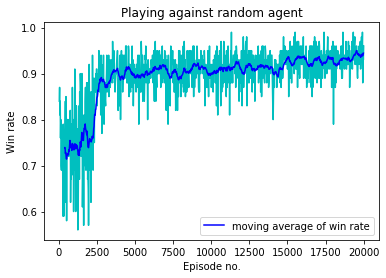

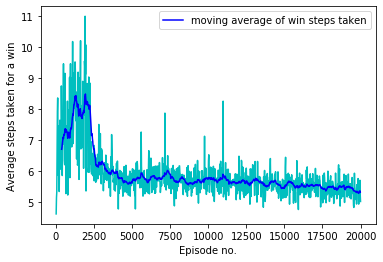

In [35]:
plt.plot(th[:, 0], th[:, 1], c='c')
win_rate_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])
plt.plot(win_rate_moving_average[:, 0], win_rate_moving_average[:, 1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(th[:, 0], th[:, 2], c='c')
win_steps_taken_moving_average = np.array([[(i + 19) * 20, np.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])
plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()

As one can see from the graph above, 
* The variance of win rate is getting smaller and the moving average for win rate is also getting higher. 
* The average win steps taken has gone down, which means the agent has learnt to win as fast as possible.

Both are the indication of the fact that our agent has learnt how to win Connect 4.

In [ ]:
path = 'DQN_plainCNN.pth'
torch.save(policy_net.state_dict(), path)

In [22]:
torch.load("DQN_plainCNN.pth", map_location=torch.device('cpu'))

OrderedDict([('conv1.weight',
              tensor([[[[ 4.3006e-02,  1.2603e-01, -1.9072e-01,  1.1640e-01, -1.1907e-01],
                        [-1.6089e-02, -1.0056e-01, -1.7590e-01,  1.5291e-01, -6.0554e-01],
                        [ 2.6408e-01,  5.6668e-02, -1.1765e-01, -6.8096e-02, -3.1047e-03],
                        [ 6.1455e-01,  2.1995e-01, -1.5309e-01,  1.6498e-01, -5.1529e-01],
                        [-6.1647e-01,  1.5737e-01,  1.4738e-01,  1.4631e-01, -4.0359e-01]]],
              
              
                      [[[ 1.3427e-01, -1.7496e-02,  1.1621e-01,  4.8718e-01, -1.1537e-01],
                        [-5.6565e-01,  4.8775e-02,  4.5431e-01, -4.0334e-01,  1.7962e-01],
                        [ 2.1896e-02, -3.1754e-01,  2.8004e-01,  9.5103e-02, -1.1268e-01],
                        [ 7.3172e-02, -1.1359e-01, -5.8517e-01, -3.7299e-01,  7.1295e-01],
                        [ 5.6931e-01, -2.1920e-01, -1.5259e-01,  1.4735e-01, -2.9850e-01]]],
              
           

# Demonstration of a trained agent playing a game

In [23]:
def demo():
    env.reset()
    env.render()

    while not env.isDone:
        state = env.board_state.copy()
        available_actions = env.get_available_actions()
        action = select_action(state, available_actions, training=False)
        # trained agent's move is denoted by O
        state, reward = env.make_move(action, 'p1')
        env.render()

        if reward == 1:
            break

        available_actions = env.get_available_actions()
        action = random_agent(available_actions)
        state, reward = env.make_move(action, 'p2')
        env.render()

demo()

,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,,,,,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,O,,,,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,,,,,
5,,,O,,,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,O,,,,
5,,,O,,,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,,,,,
4,,,O,,,X,
5,,,O,,,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,O,,,,
4,,,O,,,X,
5,,,O,,,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,,,,,
3,,,O,,,X,
4,,,O,,,X,
5,,,O,,,X,


,0,1,2,3,4,5,6
0,,,,,,,
1,,,,,,,
2,,,O,,,,
3,,,O,,,X,
4,,,O,,,X,
5,,,O,,,X,


From the above gameplay, the agent (denoted by O) knows putting in (5, 1) is a winning move even after its original strategy is blocked by p2 in step 5 by putting X in (3, 2).